# Autoencoders with TensorFlow 2 

We're going to train deep autoencoders and apply them to faces and similar images search.

Our new test subjects are human faces from the LFW face dataset (http://vis-www.cs.umass.edu/lfw/).


In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from lfw_dataset import load_lfw_dataset
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

# Load dataset
Relevant links (download the following files and put them in the same directory of the current notebook):
- http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
- http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [3]:
# load images
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)
IMG_SHAPE = X.shape[1:]

# center images
X = X.astype('float32') / 255.0 - 0.5

# split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [4]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

X shape: (986, 32, 32, 3)
attr shape: (986, 73)


1569

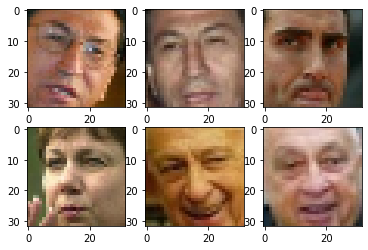

In [5]:
plt.title('sample images')

#Generate 6 random numbers
randomlist = random.sample(range(0, 99), 6)

# for i in range(6):
for i, j in enumerate(randomlist):
    plt.subplot(2,3,i+1)
    show_image(X[j])

print("X shape:", X.shape)
print("attr shape:", attr.shape)

# try to free memory
del X
import gc
gc.collect()

# Autoencoder architecture

Let's design autoencoder as two sequential keras models: the encoder and decoder respectively.

We will then use symbolic API to apply and train these models.

<img src="images/autoencoder.png" style="width:50%">

# First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

<img src="images/pca.png" style="width:30%">


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [16]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape, Conv2D, Conv2DTranspose, MaxPooling2D

In [7]:
def build_pca_autoencoder(img_shape, code_size):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    encoder = tf.keras.Sequential()
    encoder.add(Input(img_shape))
    encoder.add(Flatten())                  #flatten image to vector
    encoder.add(Dense(code_size))           #actual encoder

    decoder = tf.keras.Sequential()
    decoder.add(Input((code_size,)))
    decoder.add(Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(Reshape(img_shape))         #un-flatten
    
    return encoder,decoder

Meld them together into one model:

In [8]:
encoder, decoder = build_pca_autoencoder(IMG_SHAPE, code_size=32)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

autoencoder.fit(x=X_train, y=X_train, epochs=15,
                validation_data=[X_test, X_test],
                verbose=1)

Epoch 1/15
28/28 [==============================] - 0s 5ms/step - loss: 0.0344 - val_loss: 0.0000e+00
Epoch 2/15
28/28 [==============================] - 0s 3ms/step - loss: 0.0206 - val_loss: 0.0000e+00
Epoch 3/15
28/28 [==============================] - 0s 3ms/step - loss: 0.0168 - val_loss: 0.0000e+00
Epoch 4/15
28/28 [==============================] - 0s 3ms/step - loss: 0.0149 - val_loss: 0.0000e+00
Epoch 5/15
28/28 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.0000e+00
Epoch 6/15
28/28 [==============================] - 0s 3ms/step - loss: 0.0132 - val_loss: 0.0000e+00
Epoch 7/15
28/28 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.0000e+00
Epoch 8/15
28/28 [==============================] - 0s 3ms/step - loss: 0.0121 - val_loss: 0.0000e+00
Epoch 9/15
28/28 [==============================] - 0s 3ms/step - loss: 0.0115 - val_loss: 0.0000e+00
Epoch 10/15
28/28 [==============================] - 0s 3ms/step - loss: 0.0111 - 

In [9]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()


PCA MSE: 0.010696040466427803


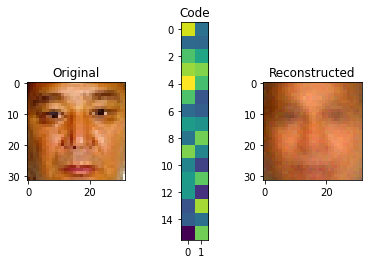

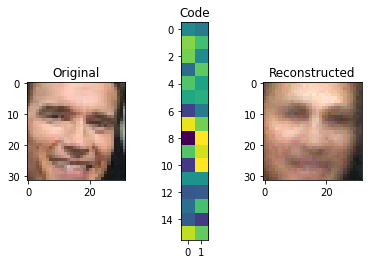

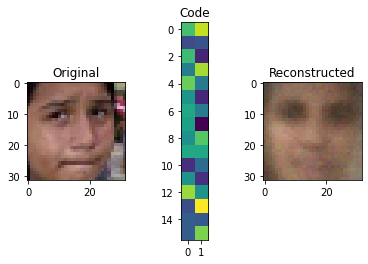

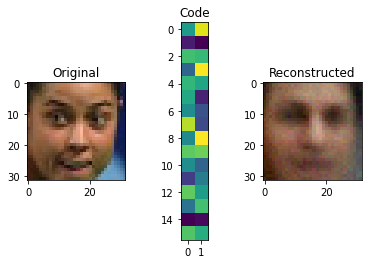

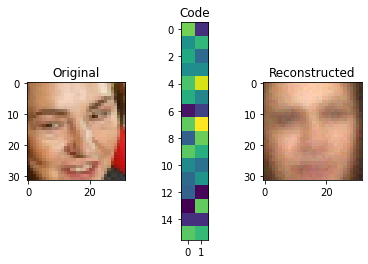

In [10]:
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("PCA MSE:", score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

# Going deeper: convolutional autoencoder

PCA is neat but surely we can do better. This time we want you to build a deep convolutional autoencoder by... stacking more layers.

## Encoder

The **encoder** part is pretty standard, we stack convolutional and pooling layers and finish with a dense layer to get the representation of desirable size (`code_size`).

We recommend to use `activation='elu'` for all convolutional and dense layers.

We recommend to repeat (conv, pool) 4 times with kernel size (3, 3), `padding='same'` and the following numbers of output channels: `32, 64, 128, 256`.

Remember to flatten (`Flatten()`) output before adding the last dense layer!

## Decoder

For **decoder** we will use so-called "transpose convolution". 

Traditional convolutional layer takes a patch of an image and produces a number (patch -> number). In "transpose convolution" we want to take a number and produce a patch of an image (number -> patch). We need this layer to "undo" convolutions in encoder. We had a glimpse of it during week 3 (watch [this video](https://www.coursera.org/learn/intro-to-deep-learning/lecture/auRqf/a-glimpse-of-other-computer-vision-tasks) starting at 5:41).

Here's how "transpose convolution" works:
<img src="images/transpose_conv.jpg" style="width:60%">
In this example we use a stride of 2 to produce 4x4 output, this way we "undo" pooling as well. Another way to think about it: we "undo" convolution with stride 2 (which is similar to conv + pool).

You can add "transpose convolution" layer in Keras like this:
```python
Conv2DTranspose(filters=?, kernel_size=(3, 3), strides=2, activation='elu', padding='same')
```

Our decoder starts with a dense layer to "undo" the last layer of encoder. Remember to reshape its output to "undo" `Flatten()` in encoder.

Now we're ready to undo (conv, pool) pairs. For this we need to stack 4 `Conv2DTranspose` layers with the following numbers of output channels: `128, 64, 32, 3`. Each of these layers will learn to "undo" (conv, pool) pair in encoder. For the last `Conv2DTranspose` layer use `activation=None` because that is our final image.

In [14]:
# Let's play around with transpose convolution on examples first
def test_conv2d_transpose(img_size, filter_size):
    print("Transpose convolution test for img_size={}, filter_size={}:".format(img_size, filter_size))
    
    x = (np.arange(img_size ** 2, dtype=np.float32) + 1).reshape((1, img_size, img_size, 1))
    f = (np.ones(filter_size ** 2, dtype=np.float32)).reshape((filter_size, filter_size, 1, 1))
    
    conv = tf.nn.conv2d_transpose(x, f, 
                                  output_shape=(1, img_size * 2, img_size * 2, 1), 
                                  strides=[1, 2, 2, 1], 
                                  padding='SAME')

    print("input:")
    print(x[0, :, :, 0])
    print("filter:")
    print(f[:, :, 0, 0])
    print("output:")
    print(conv[0, :, :, 0])
        
test_conv2d_transpose(img_size=2, filter_size=2)
test_conv2d_transpose(img_size=2, filter_size=3)
test_conv2d_transpose(img_size=4, filter_size=2)
test_conv2d_transpose(img_size=4, filter_size=3)

Transpose convolution test for img_size=2, filter_size=2:
input:
[[1. 2.]
 [3. 4.]]
filter:
[[1. 1.]
 [1. 1.]]
output:
tf.Tensor(
[[1. 1. 2. 2.]
 [1. 1. 2. 2.]
 [3. 3. 4. 4.]
 [3. 3. 4. 4.]], shape=(4, 4), dtype=float32)
Transpose convolution test for img_size=2, filter_size=3:
input:
[[1. 2.]
 [3. 4.]]
filter:
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
output:
tf.Tensor(
[[ 1.  1.  3.  2.]
 [ 1.  1.  3.  2.]
 [ 4.  4. 10.  6.]
 [ 3.  3.  7.  4.]], shape=(4, 4), dtype=float32)
Transpose convolution test for img_size=4, filter_size=2:
input:
[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 16.]]
filter:
[[1. 1.]
 [1. 1.]]
output:
tf.Tensor(
[[ 1.  1.  2.  2.  3.  3.  4.  4.]
 [ 1.  1.  2.  2.  3.  3.  4.  4.]
 [ 5.  5.  6.  6.  7.  7.  8.  8.]
 [ 5.  5.  6.  6.  7.  7.  8.  8.]
 [ 9.  9. 10. 10. 11. 11. 12. 12.]
 [ 9.  9. 10. 10. 11. 11. 12. 12.]
 [13. 13. 14. 14. 15. 15. 16. 16.]
 [13. 13. 14. 14. 15. 15. 16. 16.]], shape=(8, 8), dtype=float32)
Transpose convolution tes

In [17]:
def build_deep_autoencoder(img_shape, code_size):
    """PCA's deeper brother. See instructions above. Use `code_size` in layer definitions."""
    H,W,C = img_shape
    
    # encoder
    encoder = tf.keras.Sequential()
    encoder.add(Input(img_shape))
    encoder.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='elu'))
    encoder.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    encoder.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='elu'))
    encoder.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    encoder.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='elu'))
    encoder.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    encoder.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='elu'))
    encoder.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    encoder.add(Flatten())                  
    encoder.add(Dense(code_size))
                
    
    # decoder
    decoder = tf.keras.Sequential()
    decoder.add(Input((code_size,)))
    decoder.add(Dense(2*2*256))
    decoder.add(Reshape((2,2,256)))
    decoder.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
           
    return encoder, decoder

In [18]:
# Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512]:
    encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    assert decoder.output_shape[1:]==IMG_SHAPE,   "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 layers"
    
    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
All tests passed!


In [19]:
# Look at encoder and decoder shapes.
# Total number of trainable parameters of encoder and decoder should be close.
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 256)       

In [20]:
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

In [21]:
# we will save model checkpoints here to continue training in case of kernel death
model_filename = 'autoencoder.{0:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
# last_finished_epoch = 4
# autoencoder = tf.keras.models.load_model(model_filename.format(last_finished_epoch))
# encoder = autoencoder.layers[1]
# decoder = autoencoder.layers[2]

In [22]:
class ModelSaveCallback(tf.keras.callbacks.Callback):

    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        tf.keras.models.save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [23]:
autoencoder.fit(x=X_train, y=X_train, epochs=25,
                validation_data=[X_test, X_test],
                callbacks=[ModelSaveCallback(model_filename)],
                verbose=0,
                initial_epoch=last_finished_epoch or 0)

Model saved in autoencoder.000.hdf5
Model saved in autoencoder.001.hdf5
Model saved in autoencoder.002.hdf5
Model saved in autoencoder.003.hdf5
Model saved in autoencoder.004.hdf5
Model saved in autoencoder.005.hdf5
Model saved in autoencoder.006.hdf5
Model saved in autoencoder.007.hdf5
Model saved in autoencoder.008.hdf5
Model saved in autoencoder.009.hdf5
Model saved in autoencoder.010.hdf5
Model saved in autoencoder.011.hdf5
Model saved in autoencoder.012.hdf5
Model saved in autoencoder.013.hdf5
Model saved in autoencoder.014.hdf5
Model saved in autoencoder.015.hdf5
Model saved in autoencoder.016.hdf5
Model saved in autoencoder.017.hdf5
Model saved in autoencoder.018.hdf5
Model saved in autoencoder.019.hdf5
Model saved in autoencoder.020.hdf5
Model saved in autoencoder.021.hdf5
Model saved in autoencoder.022.hdf5
Model saved in autoencoder.023.hdf5
Model saved in autoencoder.024.hdf5


Convolutional autoencoder MSE: 0.008537352085113525


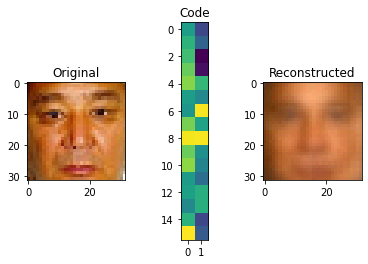

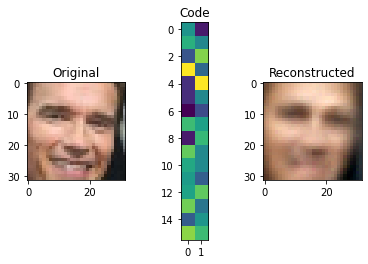

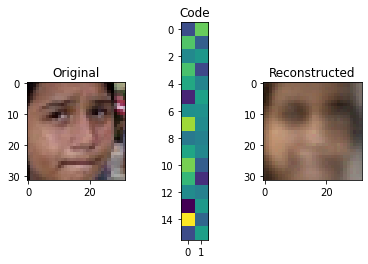

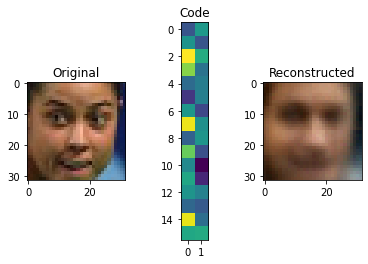

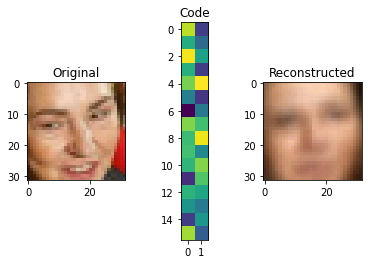

In [24]:
reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [25]:
# save trained weights
encoder.save_weights("encoder.h5")
decoder.save_weights("decoder.h5")

In [26]:
# restore trained weights
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

print(autoencoder.evaluate(X_test, X_test, verbose=0))
print(reconstruction_mse)

0.008537352085113525
0.008537352085113525


# Denoising Autoencoder

This shows you one useful application of autoencoders: denoising. You can run this code and make sure denoising works :) 

Let's now turn our model into a denoising autoencoder:

<img src="images/denoising.jpg" style="width:40%">

We'll keep the model architecture, but change the way it is trained. In particular, we'll corrupt its input data randomly with noise before each epoch.

There are many strategies to introduce noise: adding gaussian white noise, occluding with random black rectangles, etc. We will add gaussian white noise.

In [27]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from standard normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    Returns X + noise.
    """
    noise = np.random.normal(loc=0., scale=sigma, size=X.shape)
    return X + noise

In [28]:
# noise tests
theoretical_std = (X_train[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X_train[:100],sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match its required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X_train[:100],sigma=0.5).mean() - X_train[:100].mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

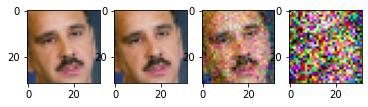

In [29]:
# test different noise scales
plt.subplot(1,4,1)
show_image(X_train[0])
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.5)[0])

Training may take long.

In [30]:
# we use bigger code size here for better quality
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=512)
assert encoder.output_shape[1:]==(512,), "encoder must output a code of required size"

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = tf.keras.Model(inp, reconstruction)
autoencoder.compile('adamax', 'mse')

for i in range(25):
    print("Epoch %i/25, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)
    
    # we continue to train our model with new noise-augmented data
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=1,
                    validation_data=[X_test_noise, X_test],
                    verbose=1)

Epoch 1/25, Generating corrupted samples...
28/28 [==============================] - 2s 61ms/step - loss: 0.0287 - val_loss: 0.0000e+00
Epoch 2/25, Generating corrupted samples...
28/28 [==============================] - 2s 55ms/step - loss: 0.0171 - val_loss: 0.0000e+00
Epoch 3/25, Generating corrupted samples...
28/28 [==============================] - 1s 53ms/step - loss: 0.0138 - val_loss: 0.0000e+00
Epoch 4/25, Generating corrupted samples...
28/28 [==============================] - 2s 59ms/step - loss: 0.0121 - val_loss: 0.0000e+00
Epoch 5/25, Generating corrupted samples...
28/28 [==============================] - 2s 54ms/step - loss: 0.0111 - val_loss: 0.0000e+00
Epoch 6/25, Generating corrupted samples...
28/28 [==============================] - 2s 56ms/step - loss: 0.0103 - val_loss: 0.0000e+00
Epoch 7/25, Generating corrupted samples...
28/28 [==============================] - 2s 56ms/step - loss: 0.0097 - val_loss: 0.0000e+00
Epoch 8/25, Generating corrupted samples...
28/2

Denoising MSE: 0.007342301309108734


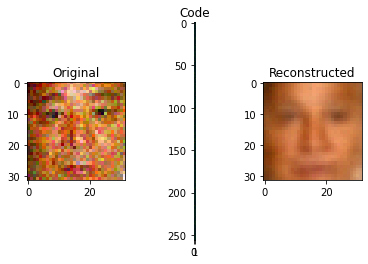

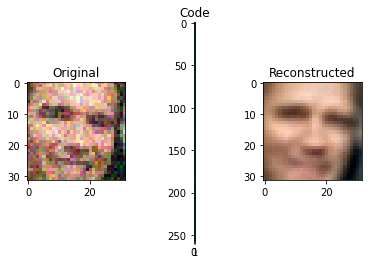

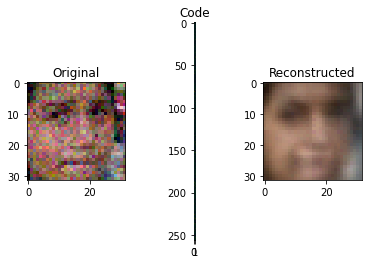

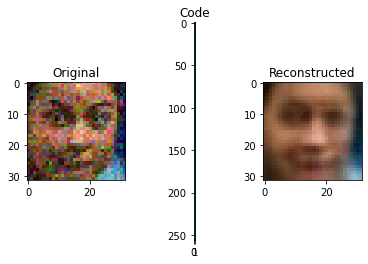

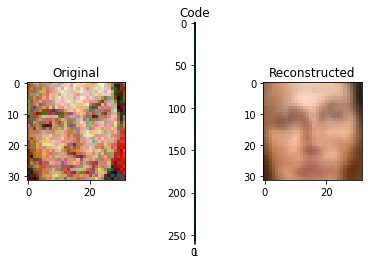

In [31]:
X_test_noise = apply_gaussian_noise(X_test)
denoising_mse = autoencoder.evaluate(X_test_noise, X_test, verbose=0)
print("Denoising MSE:", denoising_mse)
for i in range(5):
    img = X_test_noise[i]
    visualize(img,encoder,decoder)

# Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see them in action.

First thing we can do is image retrieval aka image search. We will give it an image and find similar images in latent space:

<img src="images/similar_images.jpg" style="width:60%">

To speed up retrieval process, one should use Locality Sensitive Hashing on top of encoded vectors. This [technique](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) can narrow down the potential nearest neighbours of our image in latent space (encoder code). We will caclulate nearest neighbours in brute force way for simplicity.

In [32]:
# restore trained encoder weights
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")

In [33]:
images = X_train
codes = encoder.predict(images)
assert len(codes) == len(images)

In [34]:
from sklearn.neighbors import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

NearestNeighbors(metric='euclidean')

In [35]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [36]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=3)
    
    plt.figure(figsize=[8,7])
    plt.subplot(1,4,1)
    show_image(image)
    plt.title("Original image")
    
    for i in range(3):
        plt.subplot(1,4,i+2)
        show_image(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

Cherry-picked examples:

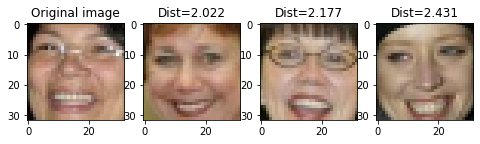

In [37]:
# smiles
show_similar(X_test[18])

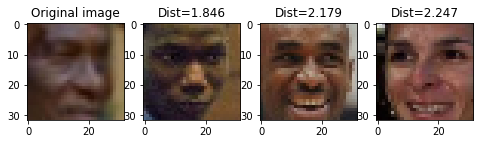

In [38]:
# ethnicity
show_similar(X_test[81])

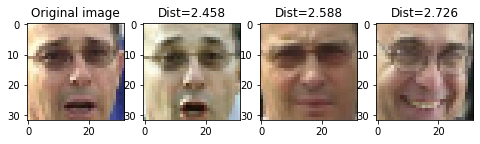

In [39]:
# glasses
show_similar(X_test[63])

# Cheap image morphing


We can take linear combinations of image codes to produce new images with decoder.

In [40]:
# restore trained encoder weights
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

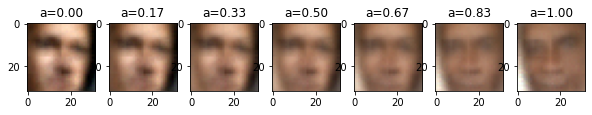

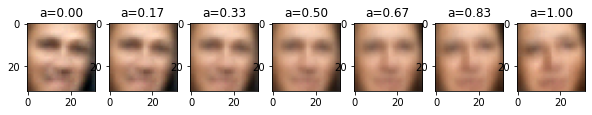

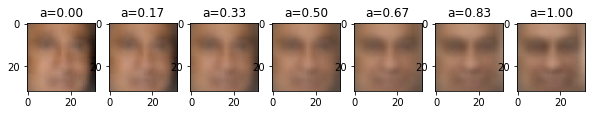

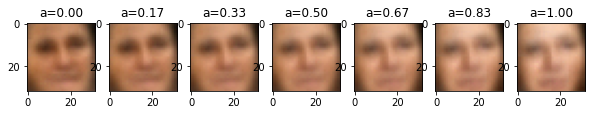

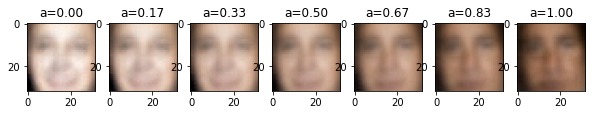

In [41]:
for _ in range(5):
    image1,image2 = X_test[np.random.randint(0,len(X_test),size=2)]

    code1, code2 = encoder.predict(np.stack([image1, image2]))

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = decoder.predict(output_code[None])[0]

        plt.subplot(1,7,i+1)
        show_image(output_image)
        plt.title("a=%.2f"%a)
        
    plt.show()

That's it!

Of course there's a lot more you can do with autoencoders.